Attempts to reproduce results in 10.1063/5.0015943.

In [1]:
from copy import deepcopy
from matplotlib import pyplot as plt
import os
from tqdm.notebook import tqdm, trange

from sde_models import Faranda2020
import sde

store_ssr_data = True
load_ssr_data = False

fig_kwargs = dict(
    layout='compressed',
    figsize=(12.0, 3.0)
)
plot_all_kwargs = dict(
    color='gray',
    alpha=0.1
)
fig_compare_kwargs = dict(
    layout='compressed', 
    figsize=(8.0, 4.0)
)

sample_size = 30
tested_sample_sizes = [30, 50, 100, 500, 1000, 5000, 10000]
confidence = 0.95

results_dir = os.path.join('results', Faranda2020.name)

def initial_values(**kwargs):
    result = {'S': 6.7E7 - 1.0,
              'E': 0.0,
              'I': 1.0,
              'R': 0.0,
              'lam': 1.0,
              'alp': 0.27,
              'gam': 0.37}
    result.update(kwargs)
    result['N'] = sum([result[k] for k in ['S', 'E', 'I', 'R']])
    result['R0'] = result['lam'] / result['gam']
    result['C'] = 0.0
    return result

def num_steps(t_fin, dt):
    return int(t_fin / dt)

if sde.get_pool() is None:
    sde.start_pool()

Attempting to reproduce Figure 1.

Qualitatively reproduces. 

  0%|          | 0/6 [00:00<?, ?it/s]

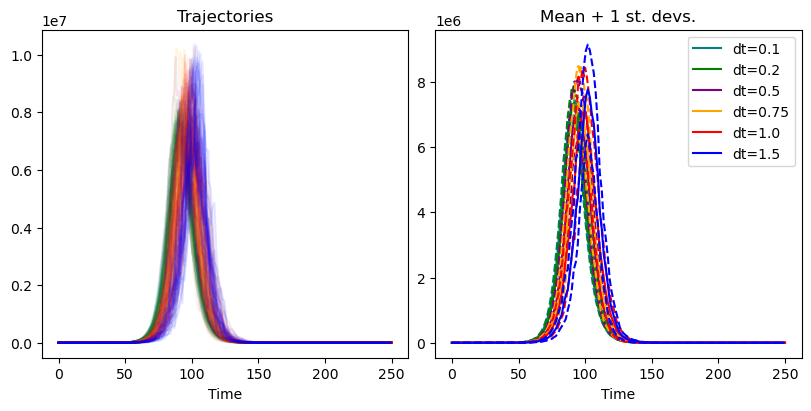

In [2]:
t_fin_fig_1 = 250.0
colors_fig_1 = ['teal', 'green', 'purple', 'orange', 'red', 'blue']
dt_fig_1 = [0.1, 0.2, 0.5, 0.75, 1.0, 1.5]
num_steps_fig_1 = {dt: num_steps(t_fin_fig_1, dt) for dt in dt_fig_1}
initial_values_fig_1 = initial_values()
parameters_fig_1 = deepcopy(Faranda2020.parameter_defaults)
n_fig_1 = 1

fig, axs = plt.subplots(1, 2, **fig_compare_kwargs)
results_fig_1 = {}

for i, dt in tqdm(enumerate(dt_fig_1), total=len(dt_fig_1), leave=False):
    results_fig_1[dt] = sde.execute_sample(sample_size, 
                                           Faranda2020(),
                                           num_steps_fig_1[dt],
                                           dt,
                                           initial_values_fig_1,
                                           parameters_fig_1).extract('I')
    results_fig_1[dt].plot(fig_axs=(fig, [axs[0]]),
                           plot_all_kwargs=dict(alpha=0.1, 
                                                color=colors_fig_1[i]))
    results_fig_1[dt].plot_mean(n_std=1,
                                fig_axs=(fig, [axs[1]]),
                                plot_all_kwargs=dict(color=colors_fig_1[i], label=f'dt={dt}'))

axs[0].set_title('Trajectories')
axs[1].set_title(f'Mean + {n_fig_1} st. devs.')
_ = axs[1].legend()

Attempting to reproduce Figure 2.

Results are qualitatively reproduced in some respects with some assumptions on inconsistencies within the text. However, insufficient sample size can produce qualitatively different outcomes. 

  0%|          | 0/3 [00:00<?, ?it/s]

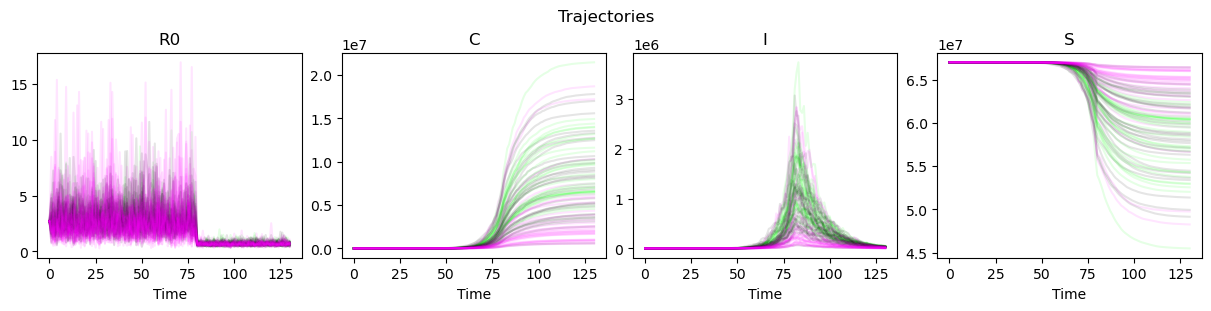

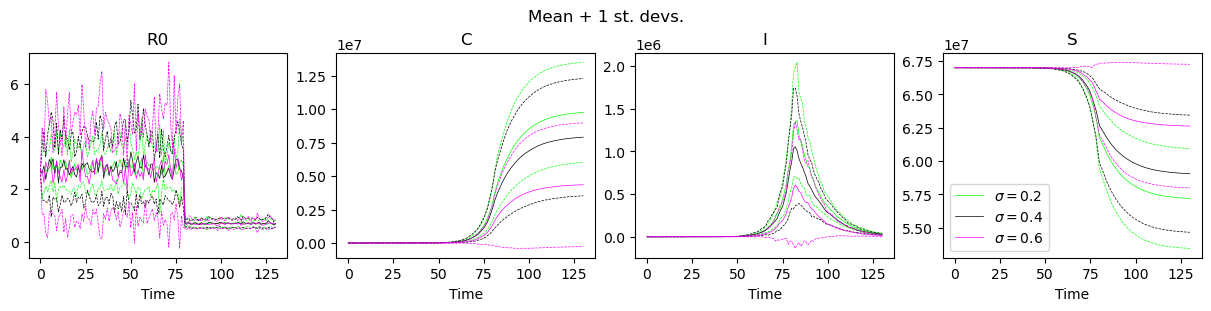

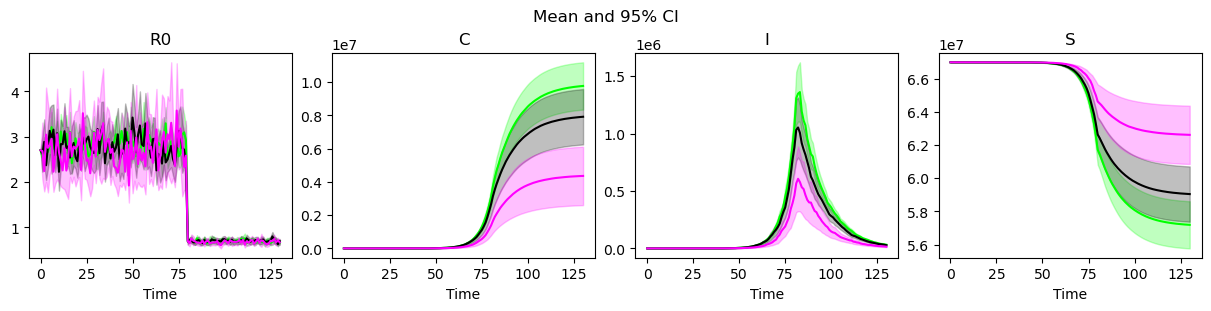

In [3]:
colors_fig_2 = ['lime', 'black', 'fuchsia']
sig_fig_2 = [0.2, 0.4, 0.6]
dt_fig_2 = 1.0
t_fin_fig_2 = 130.0
num_steps_fig_2 = num_steps(t_fin_fig_2, dt_fig_2)
initial_values_fig_2 = initial_values()
parameters_fig_2 = {sig: deepcopy(Faranda2020.parameter_defaults) for sig in sig_fig_2}

fig_axs_traj = None
fig_axs_stat = None
fig_axs_ci = None
results_fig_2 = {}

for i, sig in tqdm(enumerate(sig_fig_2), total=len(sig_fig_2), leave=False):
    parameters_fig_2[sig]['lam_std'] = sig
    parameters_fig_2[sig]['int_time_0'] = 78.0  # Text says 80, figure caption says 78
    parameters_fig_2[sig]['int_val_0'] = 0.25
    res = sde.execute_sample(sample_size,
                             Faranda2020(),
                             num_steps_fig_2,
                             dt_fig_2,
                             initial_values_fig_2,
                             parameters_fig_2[sig]).extract('R0', 'C', 'I', 'S')
    results_fig_2[sig] = res

    fig_axs_traj = res.plot(fig_kwargs=fig_kwargs,
                            fig_axs=fig_axs_traj,
                            plot_all_kwargs=dict(alpha=0.1, color=colors_fig_2[i]))
    fig_axs_stat = res.plot_mean(n_std=1,
                                 fig_kwargs=fig_kwargs,
                                 fig_axs=fig_axs_stat,
                                 plot_all_kwargs=dict(color=colors_fig_2[i], 
                                                      label=f'$\\sigma={sig}$',
                                                      linewidth=0.5))
    fig_axs_ci = res.plot_ci(confidence=confidence,
                             fig_kwargs=fig_kwargs,
                             fig_axs=fig_axs_ci,
                             plot_all_kwargs=dict(color=colors_fig_2[i], alpha=0.25))
    fig_axs_ci = res.plot_mean(fig_kwargs=fig_kwargs,
                               fig_axs=fig_axs_ci,
                               plot_all_kwargs=dict(color=colors_fig_2[i]))

fig_axs_stat[1][-1].legend()
fig_axs_traj[0].suptitle('Trajectories')
fig_axs_stat[0].suptitle(f'Mean + {n_fig_1} st. devs.')
_ = fig_axs_ci[0].suptitle(f'Mean and {int(confidence * 100)}% CI')

Note how at the given sample size, qualitative outcomes can be different per sample. For example, Figure 2 reports the average final value of $C$ as being greater with decreasing $\sigma$. Testing multiple samples demonstrates that this outcome is not is not reliably reproducible. 

In [4]:
num_iters = 10000
num_correct = 0

for j in trange(num_iters, leave=False):
    res_iter_fin = [sde.execute_sample(sample_size, 
                                       Faranda2020(),
                                       num_steps_fig_2,
                                       dt_fig_2,
                                       initial_values_fig_2,
                                       parameters_fig_2[sig]).extract('C').mean[0, -1] 
                    for sig in sig_fig_2]
    res_iter_fin_ordered = res_iter_fin.copy()
    res_iter_fin_ordered.sort()
    res_iter_fin_ordered.reverse()
    if res_iter_fin == res_iter_fin_ordered:
        num_correct += 1

print(f'{num_correct / num_iters * 100}% of {num_iters} runs produce the same qualitative outcome as the publication.')

  0%|          | 0/10000 [00:00<?, ?it/s]

73.63% of 10000 runs produce the same qualitative outcome as the publication.


Attempting to reproduce Figure 3.

Does not reproduce. Means do not tend towards the same final value.

  0%|          | 0/3 [00:00<?, ?it/s]

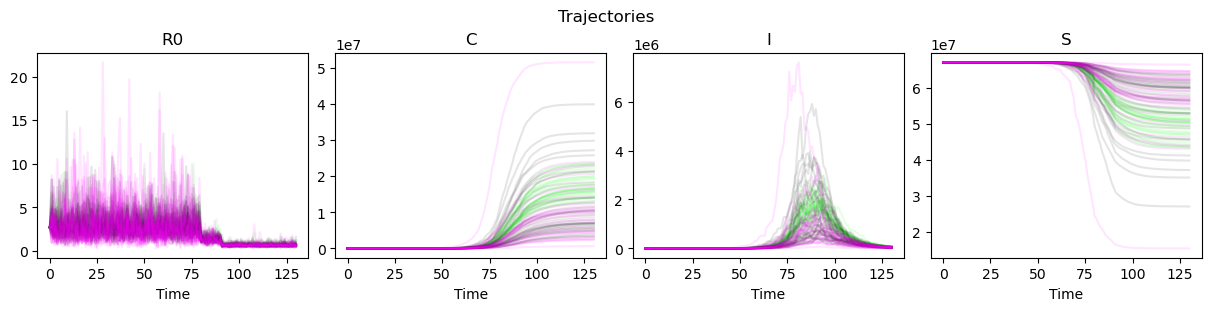

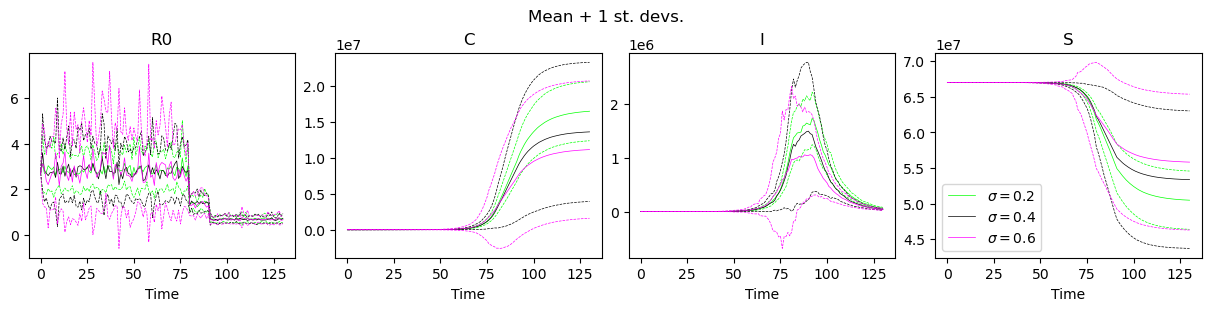

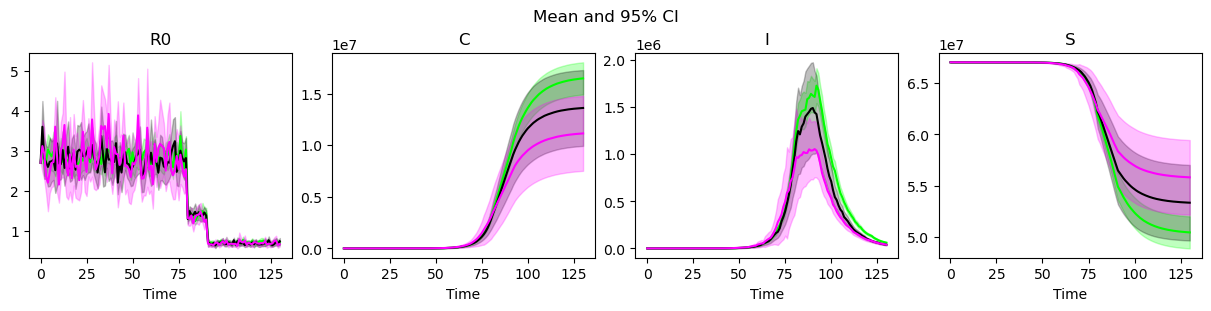

In [5]:
colors_fig_3 = ['lime', 'black', 'fuchsia']
sig_fig_3 = [0.2, 0.4, 0.6]
dt_fig_3 = 1.0
t_fin_fig_3 = 130.0
num_steps_fig_3 = num_steps(t_fin_fig_3, dt_fig_3)
initial_values_fig_3 = initial_values()
parameters_fig_3 = {}

fig_axs_traj = None
fig_axs_stat = None
fig_axs_ci = None
results_fig_3 = {}

for i, sig in tqdm(enumerate(sig_fig_3), total=len(sig_fig_3), leave=False):
    parameters_fig_3[sig] = deepcopy(Faranda2020.parameter_defaults)
    parameters_fig_3[sig]['lam_std'] = sig
    parameters_fig_3[sig]['int_time_0'] = 78.0
    parameters_fig_3[sig]['int_val_0'] = 0.50
    parameters_fig_3[sig]['int_time_1'] = 89.0
    parameters_fig_3[sig]['int_val_1'] = 0.25
    res = sde.execute_sample(sample_size,
                             Faranda2020(),
                             num_steps_fig_3,
                             dt_fig_3,
                             initial_values_fig_3,
                             parameters_fig_3[sig]).extract('R0', 'C', 'I', 'S')
    results_fig_3[sig] = res

    fig_axs_traj = res.plot(fig_kwargs=fig_kwargs,
                            fig_axs=fig_axs_traj,
                            plot_all_kwargs=dict(alpha=0.1, color=colors_fig_3[i]))
    fig_axs_stat = res.plot_mean(n_std=1,
                                 fig_kwargs=fig_kwargs,
                                 fig_axs=fig_axs_stat,
                                 plot_all_kwargs=dict(color=colors_fig_3[i], 
                                                      label=f'$\\sigma={sig}$',
                                                      linewidth=0.5))
    fig_axs_ci = res.plot_ci(confidence=confidence,
                             fig_kwargs=fig_kwargs,
                             fig_axs=fig_axs_ci,
                             plot_all_kwargs=dict(color=colors_fig_3[i], alpha=0.25))
    fig_axs_ci = res.plot_mean(fig_kwargs=fig_kwargs,
                               fig_axs=fig_axs_ci,
                               plot_all_kwargs=dict(color=colors_fig_3[i]))

fig_axs_stat[1][-1].legend()
fig_axs_traj[0].suptitle('Trajectories')
fig_axs_stat[0].suptitle(f'Mean + {n_fig_1} st. devs.')
_ = fig_axs_ci[0].suptitle(f'Mean and {int(confidence * 100)}% CI')

Attempting to reproduce Figure 4.

Does not reproduce without corrections. Scenario "Distancing Measures" is clearly different. A reduction value of 40% produces results that are more similar to those reported with a reduction value of 50%.

  0%|          | 0/3 [00:00<?, ?it/s]

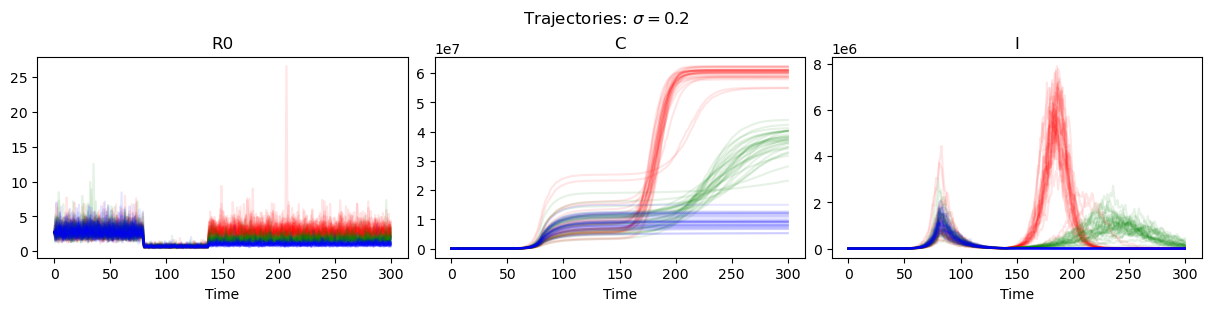

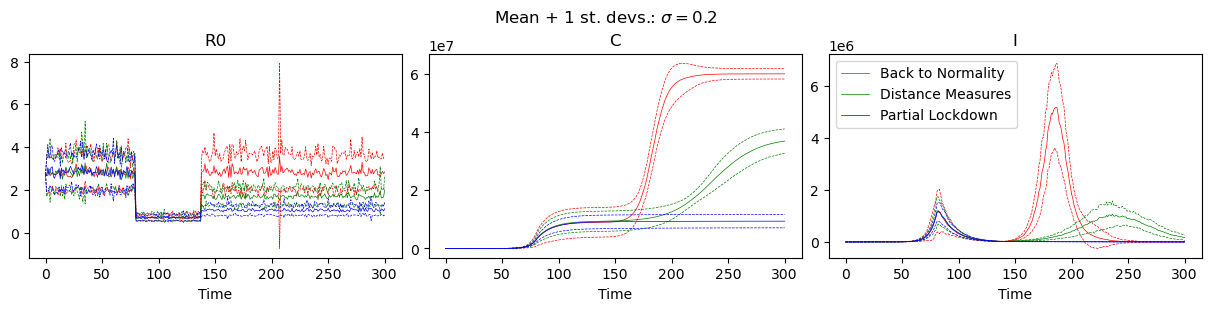

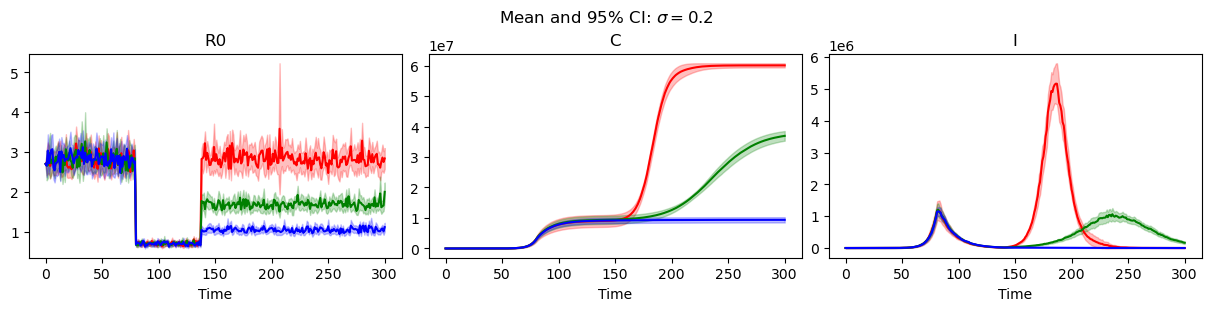

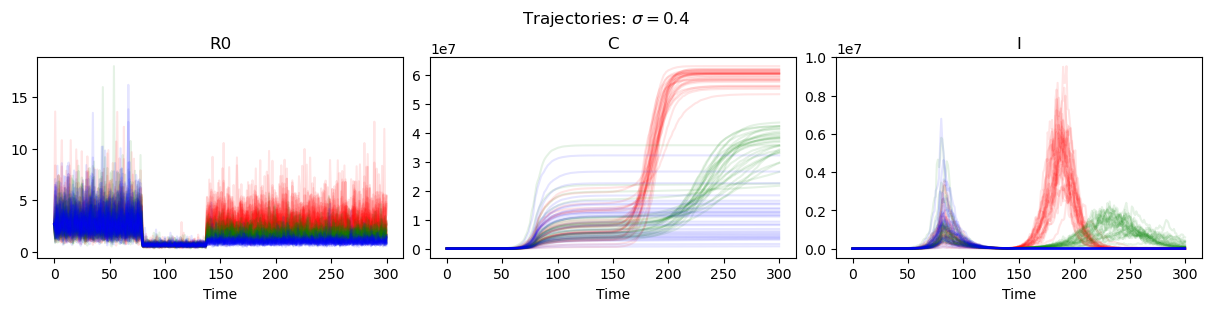

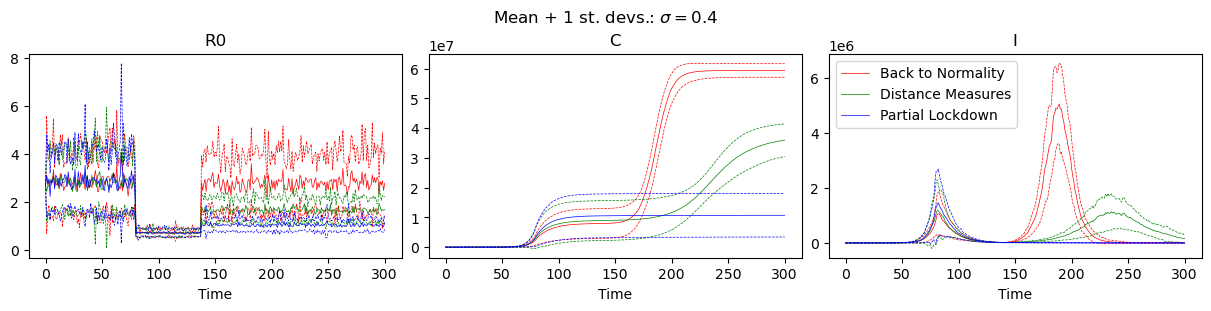

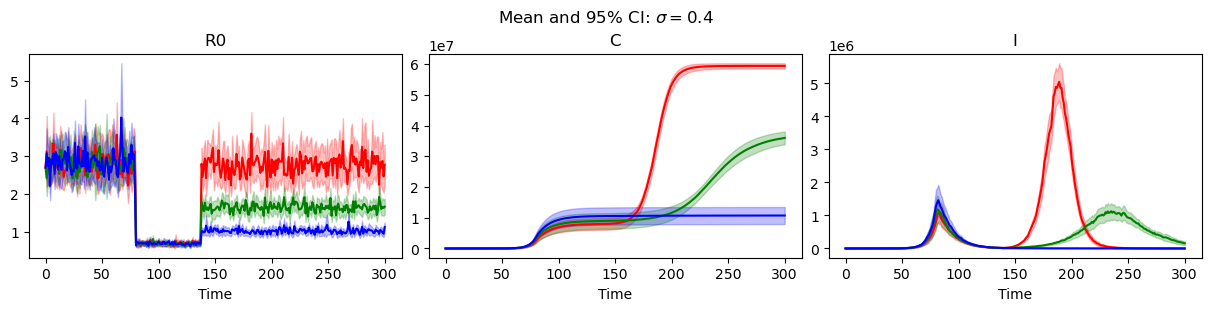

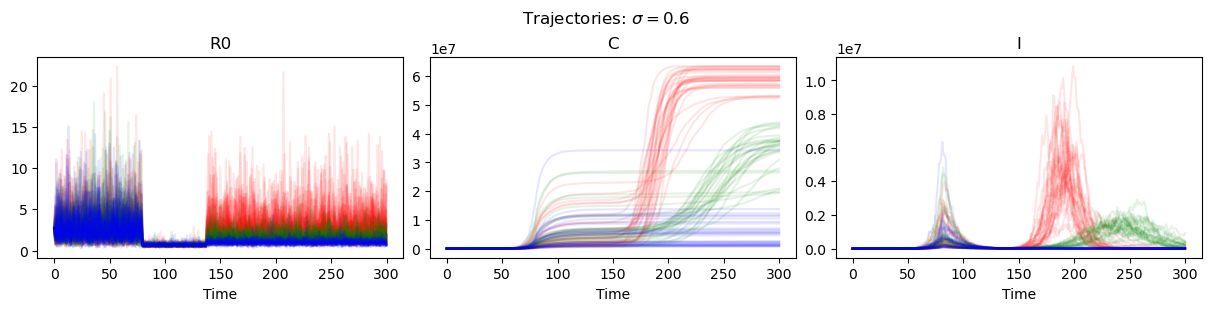

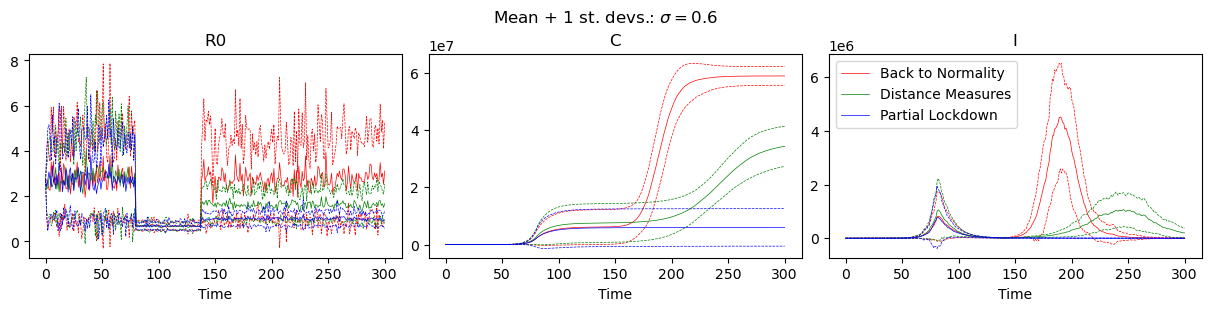

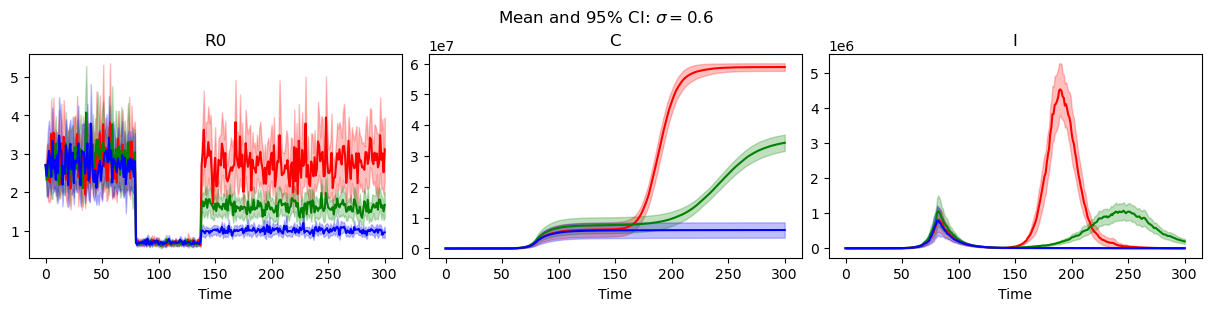

In [6]:
colors_fig_4 = ['red', 'green', 'blue']
labels_fig_4 = ['Back to Normality', 'Distance Measures', 'Partial Lockdown']
sig_fig_4 = [0.2, 0.4, 0.6]
# int_val_1_fig_4 = [1.0, 0.5, Faranda2020.parameter_defaults['gam_0'] / Faranda2020.parameter_defaults['lam_0']]
int_val_1_fig_4 = [1.0, 0.6, Faranda2020.parameter_defaults['gam_0'] / Faranda2020.parameter_defaults['lam_0']]  # Correction
dt_fig_4 = 1.0
t_fin_fig_4 = 300.0
num_steps_fig_4 = num_steps(t_fin_fig_4, dt_fig_4)
initial_values_fig_4 = initial_values()
parameters_fig_4 = {sig: {} for sig in sig_fig_4}

results_fig_4 = {sig: {} for sig in sig_fig_4}
for i, sig in tqdm(enumerate(sig_fig_4), total=len(sig_fig_4), leave=False):
    for val in int_val_1_fig_4:
        parameters_fig_4[sig][val] = deepcopy(Faranda2020.parameter_defaults)
        parameters_fig_4[sig][val]['lam_std'] = sig
        parameters_fig_4[sig][val]['int_time_0'] = 78.0
        parameters_fig_4[sig][val]['int_val_0'] = 0.25
        parameters_fig_4[sig][val]['int_time_1'] = 136.0
        parameters_fig_4[sig][val]['int_val_1'] = val
        results_fig_4[sig][val] = sde.execute_sample(sample_size,
                                                     Faranda2020(),
                                                     num_steps_fig_4,
                                                     dt_fig_4,
                                                     initial_values_fig_4,
                                                     parameters_fig_4[sig][val]).extract('R0', 'C', 'I')

    fig_axs_traj = None
    fig_axs_stat = None
    fig_axs_ci = None
    for j, val in enumerate(int_val_1_fig_4):
        res = results_fig_4[sig][val]
        fig_axs_traj = res.plot(fig_kwargs=fig_kwargs,
                                fig_axs=fig_axs_traj,
                                plot_all_kwargs=dict(alpha=0.1, color=colors_fig_4[j]))
        fig_axs_stat = res.plot_mean(n_std=1,
                                    fig_kwargs=fig_kwargs,
                                    fig_axs=fig_axs_stat,
                                    plot_all_kwargs=dict(color=colors_fig_4[j], 
                                                         label=labels_fig_4[j],
                                                         linewidth=0.5))
        fig_axs_ci = res.plot_ci(confidence=confidence,
                                 fig_kwargs=fig_kwargs,
                                 fig_axs=fig_axs_ci,
                                 plot_all_kwargs=dict(color=colors_fig_4[j], alpha=0.25))
        fig_axs_ci = res.plot_mean(fig_kwargs=fig_kwargs,
                                   fig_axs=fig_axs_ci,
                                   plot_all_kwargs=dict(color=colors_fig_4[j]))

    fig_axs_stat[1][-1].legend()
    fig_axs_traj[0].suptitle(f'Trajectories: $\sigma={sig}$')
    fig_axs_stat[0].suptitle(f'Mean + {n_fig_1} st. devs.: $\sigma={sig}$')
    _ = fig_axs_ci[0].suptitle(f'Mean and {int(confidence * 100)}% CI: $\sigma={sig}$')

Cannot reproduce Figure 5. Insufficient information reported (reductions in $R_0$). 

Quantify reproducibility of Figure 1.

Figure 1 Results EFECT Error (mean +- st. dev)
dt: 0.1
	Sample size 30: 0.9499068626601505 +- 0.04096776944312383
	Sample size 50: 0.743379838128664 +- 0.03216990577452512
	Sample size 100: 0.5303994036517333 +- 0.02688723345212776
	Sample size 500: 0.238756955711638 +- 0.01002625161865464
	Sample size 1000: 0.16835362515798635 +- 0.00771176986676709
	Sample size 5000: 0.0752591773935747 +- 0.0033043555715120757
	Sample size 10000: 0.05312317809231424 +- 0.002378098143144435
dt: 0.2
	Sample size 30: 0.9296291025561658 +- 0.041093380108277185
	Sample size 50: 0.7241614379685072 +- 0.032428912162564036
	Sample size 100: 0.5154193783182532 +- 0.02383224892102651
	Sample size 500: 0.23130257740332538 +- 0.011503370767054669
	Sample size 1000: 0.16473271970213652 +- 0.007515686399799051
	Sample size 5000: 0.0735537848902716 +- 0.0034069942958618454
	Sample size 10000: 0.05219484443918608 +- 0.0025600991121196145
dt: 0.5
	Sample size 30: 0.899670583327711 +- 0.044506356101162686
	Sample size

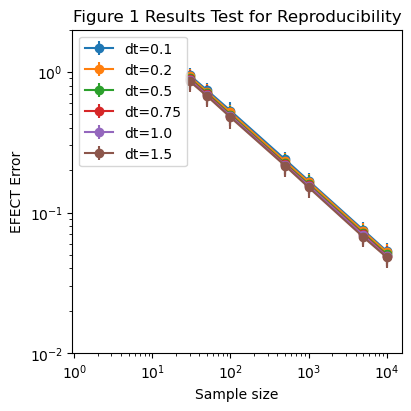

In [7]:
prefix_fig_1 = 'results_fig_1'

ssr_metadata_fig_1 = {}
ssr_results_fig_1 = {}

if load_ssr_data:
    md_data, res_data = sde.load_ssr_dataset(results_dir, prefix_fig_1)[:2]
    for i in range(len(md_data)):
        dt_i = res_data[i].time[1] - res_data[i].time[0]
        if dt_i not in ssr_metadata_fig_1:
            ssr_metadata_fig_1[dt_i] = {}
            ssr_results_fig_1[dt_i] = {}
        ssr_metadata_fig_1[dt_i][md_data[i].sample_size] = md_data[i]
        ssr_results_fig_1[dt_i][md_data[i].sample_size] = res_data[i]
else:
    for i, dt in tqdm(enumerate(dt_fig_1), total=len(dt_fig_1), leave=False):
        ssr_metadata_fig_1[dt], ssr_results_fig_1[dt] = sde.generate_ssr_dataset(
            Faranda2020(),
            tested_sample_sizes,
            num_steps_fig_1[dt],
            dt,
            initial_values_fig_1,
            parameters_fig_1,
            prefix_fig_1 + f'_{i}',
            results_dir=results_dir if store_ssr_data else None
        )

fig_ax = None
for dt, res in ssr_metadata_fig_1.items():
    fig_ax = sde.plot_repro(res,
                            fig_ax=fig_ax,
                            plot_kwargs=dict(label=f'dt={dt}'))
fig_ax[1].legend()
fig_ax[1].set_title(f'Figure 1 Results Test for Reproducibility')

print('Figure 1 Results EFECT Error (mean +- st. dev)')
for dt, res in ssr_metadata_fig_1.items():
    print('dt:', dt)
    for sz, md in res.items():
        print(f'\tSample size {sz}: {md.ks_stat_mean} +- {md.ks_stat_stdev}')

Quantify reproducibility of Figure 2.

Figure 2 Results EFECT Error (mean +- st. dev)
sigma: 0.2
	Sample size 30: 0.857181339588293 +- 0.049422111612198324
	Sample size 50: 0.667059067521657 +- 0.03652638056650164
	Sample size 100: 0.47564437545271004 +- 0.026568947119721728
	Sample size 500: 0.21339685053429452 +- 0.012011461960917723
	Sample size 1000: 0.15032847702862573 +- 0.007096981820489208
	Sample size 5000: 0.06757425946502822 +- 0.003816151336121844
	Sample size 10000: 0.04778369652910044 +- 0.002767641410975276
sigma: 0.4
	Sample size 30: 0.8520939969064552 +- 0.047216814315190314
	Sample size 50: 0.6645980224791816 +- 0.03753788540198352
	Sample size 100: 0.4750814588680962 +- 0.027115000043867722
	Sample size 500: 0.21126163622431476 +- 0.011650212767799054
	Sample size 1000: 0.14989297682953412 +- 0.008556319322826062
	Sample size 5000: 0.06684074586790203 +- 0.003797394284017705
	Sample size 10000: 0.04778874047444465 +- 0.002943941755075733
sigma: 0.6
	Sample size 30: 0.8473629355824275 +- 0.0433287184093174

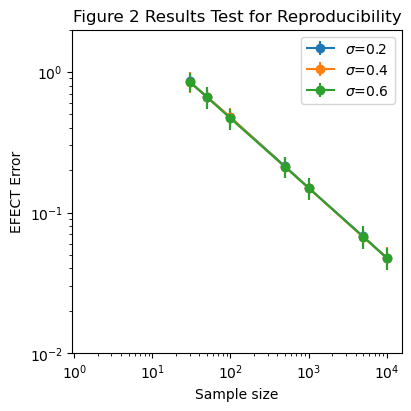

In [8]:
prefix_fig_2 = 'results_fig_2'

ssr_metadata_fig_2 = {}
ssr_results_fig_2 = {}

if load_ssr_data:
    md_data, res_data, iv_data, p_data, _ = sde.load_ssr_dataset(results_dir, prefix_fig_2)
    for i in range(len(md_data)):
        sig = p_data[i]['lam_std']
        if sig not in ssr_metadata_fig_2:
            ssr_metadata_fig_2[sig] = {}
            ssr_results_fig_2[sig] = {}
        ssr_metadata_fig_2[sig][md_data[i].sample_size] = md_data[i]
        ssr_results_fig_2[sig][md_data[i].sample_size] = res_data[i]
else:
    for i, sig in tqdm(enumerate(sig_fig_2), total=len(sig_fig_2), leave=False):
        ssr_metadata_fig_2[sig], ssr_results_fig_2[sig] = sde.generate_ssr_dataset(
            Faranda2020(),
            tested_sample_sizes,
            num_steps_fig_2,
            dt_fig_2,
            initial_values_fig_2,
            parameters_fig_2[sig],
            prefix_fig_2 + f'_{i}',
            results_dir=results_dir if store_ssr_data else None
        )

fig_ax = None
for sig, res in ssr_metadata_fig_2.items():
    fig_ax = sde.plot_repro(res,
                            fig_ax=fig_ax,
                            plot_kwargs=dict(label=f'$\\sigma$={sig}'))
fig_ax[1].legend()
fig_ax[1].set_title(f'Figure 2 Results Test for Reproducibility')

print('Figure 2 Results EFECT Error (mean +- st. dev)')
for sig, res in ssr_metadata_fig_2.items():
    print('sigma:', sig)
    for sz, md in res.items():
        print(f'\tSample size {sz}: {md.ks_stat_mean} +- {md.ks_stat_stdev}')

Quantify reproducibility of Figure 3.

Figure 3 Results EFECT Error (mean +- st. dev)
sigma: 0.2
	Sample size 30: 0.8564167117837251 +- 0.04639939275534849
	Sample size 50: 0.6689249488794119 +- 0.03821239501302343
	Sample size 100: 0.473570465106444 +- 0.024032107509188428
	Sample size 500: 0.21369673920510648 +- 0.011406102780086453
	Sample size 1000: 0.15016039014797145 +- 0.008493487730895019
	Sample size 5000: 0.06740485728323171 +- 0.0037001484158632157
	Sample size 10000: 0.047808742685305 +- 0.0028841151840708922
sigma: 0.4
	Sample size 30: 0.853703420549213 +- 0.044863260798742165
	Sample size 50: 0.6658787001717675 +- 0.03423659487362706
	Sample size 100: 0.475202331183764 +- 0.0273967136867664
	Sample size 500: 0.21219509028574585 +- 0.011318613136524446
	Sample size 1000: 0.15097511098325686 +- 0.008619873071392512
	Sample size 5000: 0.06720392201412137 +- 0.003864999183217755
	Sample size 10000: 0.0477362326606859 +- 0.002688721588433029
sigma: 0.6
	Sample size 30: 0.8478513359584686 +- 0.04530216815311402
	Sam

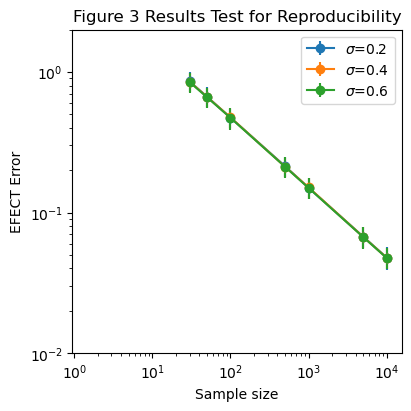

In [9]:
prefix_fig_3 = 'results_fig_3'

ssr_metadata_fig_3 = {}
ssr_results_fig_3 = {}

if load_ssr_data:
    md_data, res_data, iv_data, p_data, _ = sde.load_ssr_dataset(results_dir, prefix_fig_3)
    for i in range(len(md_data)):
        sig = p_data[i]['lam_std']
        if sig not in ssr_metadata_fig_3:
            ssr_metadata_fig_3[sig] = {}
            ssr_results_fig_3[sig] = {}
        ssr_metadata_fig_3[sig][md_data[i].sample_size] = md_data[i]
        ssr_results_fig_3[sig][md_data[i].sample_size] = res_data[i]
else:
    for i, sig in tqdm(enumerate(sig_fig_3), total=len(sig_fig_3), leave=False):
        ssr_metadata_fig_3[sig], ssr_results_fig_3[sig] = sde.generate_ssr_dataset(
            Faranda2020(),
            tested_sample_sizes,
            num_steps_fig_3,
            dt_fig_3,
            initial_values_fig_3,
            parameters_fig_3[sig],
            prefix_fig_3 + f'_{i}',
            results_dir=results_dir if store_ssr_data else None
        )

fig_ax = None
for sig, res in ssr_metadata_fig_3.items():
    fig_ax = sde.plot_repro(res,
                            fig_ax=fig_ax,
                            plot_kwargs=dict(label=f'$\\sigma$={sig}'))
fig_ax[1].legend()
fig_ax[1].set_title('Figure 3 Results Test for Reproducibility')

print('Figure 3 Results EFECT Error (mean +- st. dev)')
for sig, res in ssr_metadata_fig_3.items():
    print('sigma:', sig)
    for sz, md in res.items():
        print(f'\tSample size {sz}: {md.ks_stat_mean} +- {md.ks_stat_stdev}')

Quantify reproducibility of Figure 4.

Figure 4 Results EFECT Error (mean +- st. dev)
sigma: 0.2 intervention value: 1.0
	Sample size 30: 0.8793326977217943 +- 0.04164841610226039
	Sample size 50: 0.6874407006273181 +- 0.03439152362938002
	Sample size 100: 0.49058698292915853 +- 0.026405989754573287
	Sample size 500: 0.22012067754628425 +- 0.011365326865597004
	Sample size 1000: 0.15534508594787122 +- 0.007552861884903197
	Sample size 5000: 0.06964669101722393 +- 0.0034411437677119043
	Sample size 10000: 0.04933660104643419 +- 0.0027828473860745094
sigma: 0.2 intervention value: 0.6
	Sample size 30: 0.881714148754046 +- 0.04184722322435858
	Sample size 50: 0.6895418807534596 +- 0.036135539572622485
	Sample size 100: 0.48949524942226263 +- 0.025918463308620975
	Sample size 500: 0.22044287234023263 +- 0.012097705922099298
	Sample size 1000: 0.15544710201811762 +- 0.007766977329138429
	Sample size 5000: 0.07019975958390065 +- 0.00393991521163227
	Sample size 10000: 0.04936282921807252 +- 0.00261625379603729
sigma: 0.2 interven

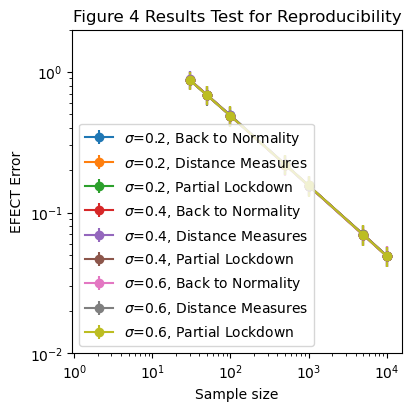

In [15]:
prefix_fig_4 = 'results_fig_4'

ssr_metadata_fig_4 = {}
ssr_results_fig_4 = {}

if load_ssr_data:
    md_data, res_data, iv_data, p_data, _ = sde.load_ssr_dataset(results_dir, prefix_fig_4)
    for i in range(len(md_data)):
        sig = p_data[i]['lam_std']
        ival = p_data[i]['int_val_1']
        if sig not in ssr_metadata_fig_4:
            ssr_metadata_fig_4[sig] = {}
            ssr_results_fig_4[sig] = {}
        if ival not in ssr_metadata_fig_4[sig]:
            ssr_metadata_fig_4[sig][ival] = {}
            ssr_results_fig_4[sig][ival] = {}
        ssr_metadata_fig_4[sig][ival][md_data[i].sample_size] = md_data[i]
        ssr_results_fig_4[sig][ival][md_data[i].sample_size] = res_data[i]
else:
    for i, sig in tqdm(enumerate(sig_fig_4), total=len(sig_fig_4), leave=False):
        ssr_metadata_fig_4[sig] = {}
        ssr_results_fig_4[sig] = {}
        for j, ival in enumerate(int_val_1_fig_4):
            ssr_metadata_fig_4[sig][ival], ssr_results_fig_4[sig][ival] = sde.generate_ssr_dataset(
                Faranda2020(),
                tested_sample_sizes,
                num_steps_fig_4,
                dt_fig_4,
                initial_values_fig_4,
                parameters_fig_4[sig][ival],
                prefix_fig_4 + f'_{i}_{j}',
                results_dir=results_dir if store_ssr_data else None
            )

fig_ax = None
for sig, res in ssr_metadata_fig_4.items():
    for i, ival in enumerate(res.keys()):
        fig_ax = sde.plot_repro(res[ival],
                                fig_ax=fig_ax,
                                plot_kwargs=dict(label=f'$\\sigma$={sig}, {labels_fig_4[i]}'))
fig_ax[1].set_title('Figure 4 Results Test for Reproducibility')
fig_ax[1].legend()

print('Figure 4 Results EFECT Error (mean +- st. dev)')
for sig, res in ssr_metadata_fig_4.items():
    for ival, res_ival in res.items():
        print('sigma:', sig, 'intervention value:', ival)
        for sz, md in res_ival.items():
            print(f'\tSample size {sz}: {md.ks_stat_mean} +- {md.ks_stat_stdev}')

Show reproducible results for Figure 1.

  0%|          | 0/6 [00:00<?, ?it/s]

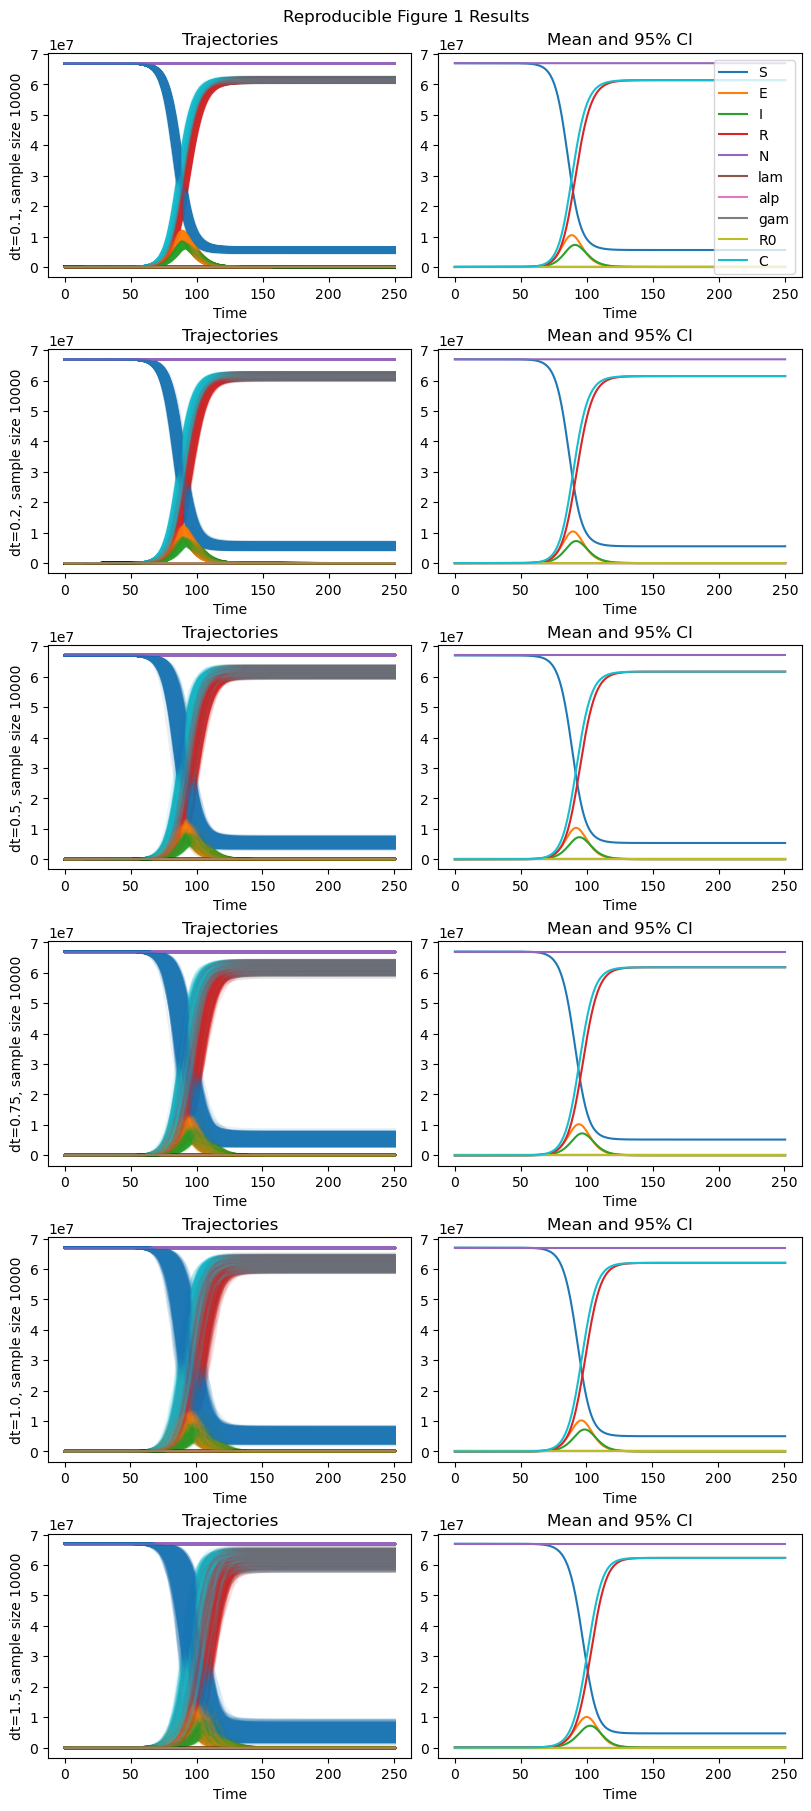

In [11]:
fig_compare_kwargs_fig_1 = deepcopy(fig_compare_kwargs)
fig_compare_kwargs_fig_1['figsize'] = (fig_compare_kwargs['figsize'][0], 3.0 * len(ssr_metadata_fig_1.keys()))
fig, axs = plt.subplots(len(ssr_metadata_fig_1.keys()), 2, **fig_compare_kwargs_fig_1)

for i, dt in tqdm(enumerate(ssr_results_fig_1.keys()), total=len(ssr_results_fig_1.keys()), leave=False):

       res = ssr_results_fig_1[dt]

       ssr_results_fig_1_sz = max(res.keys())

       r: sde.SDEResultSample = res[ssr_results_fig_1_sz]
       r.plot(fig_axs=(fig, [axs[i][0]] * len(Faranda2020.variable_names)), plot_all_kwargs=dict(alpha=0.1))

       r.plot_ci(confidence, fig_axs=(fig, [axs[i][1]] * len(Faranda2020.variable_names)), 
                 plot_all_kwargs=dict(alpha=0.25))
       r.plot_mean(fig_axs=(fig, [axs[i][1]] * len(Faranda2020.variable_names)), 
                   plot_kwargs={n: dict(label=n) for n in Faranda2020.variable_names})

       axs[i][0].set_ylabel(f'dt={dt}, sample size {ssr_results_fig_1_sz}')
       axs[i][0].set_title('Trajectories')
       axs[i][1].set_title(f'Mean and {int(confidence * 100)}% CI')
fig.suptitle(f'Reproducible Figure 1 Results')
_ = axs[0][1].legend()

Show reproducible results for Figure 2.

  0%|          | 0/3 [00:00<?, ?it/s]

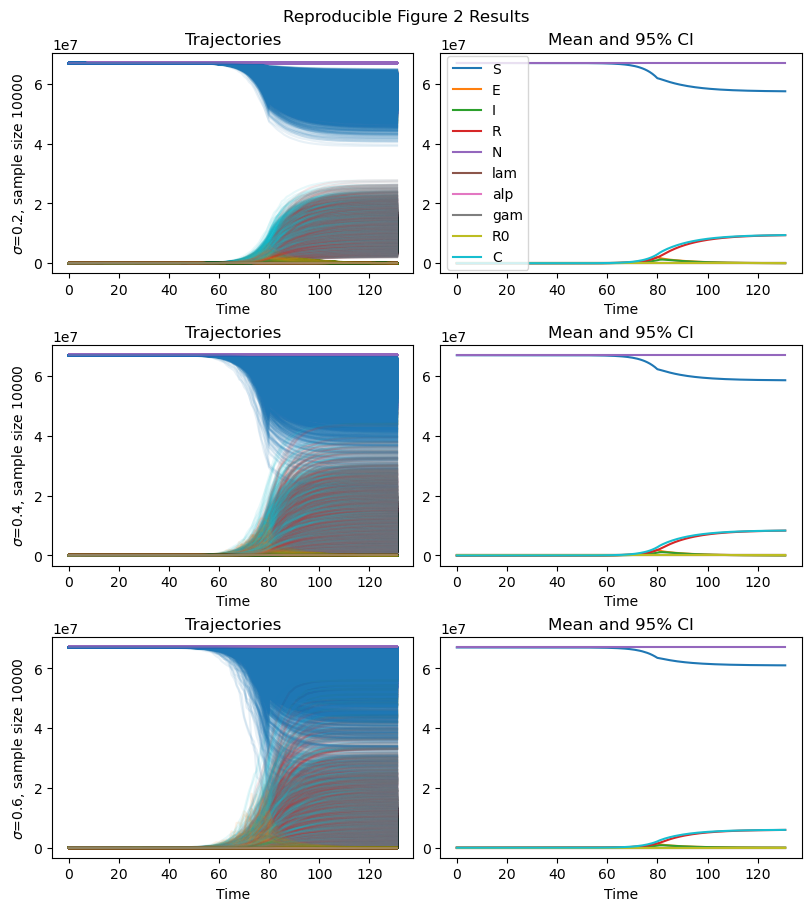

In [12]:
fig_compare_kwargs_fig_2 = deepcopy(fig_compare_kwargs)
fig_compare_kwargs_fig_2['figsize'] = (fig_compare_kwargs['figsize'][0], 3.0 * len(ssr_metadata_fig_2.keys()))
fig, axs = plt.subplots(len(ssr_metadata_fig_2.keys()), 2, **fig_compare_kwargs_fig_2)

for i, sig in tqdm(enumerate(ssr_results_fig_2.keys()), total=len(ssr_results_fig_2.keys()), leave=False):

       res = ssr_results_fig_2[sig]

       ssr_results_fig_2_sz = max(res.keys())

       r: sde.SDEResultSample = res[ssr_results_fig_2_sz]
       r.plot(fig_axs=(fig, [axs[i][0]] * len(Faranda2020.variable_names)), plot_all_kwargs=dict(alpha=0.1))

       r.plot_ci(confidence, fig_axs=(fig, [axs[i][1]] * len(Faranda2020.variable_names)), 
                 plot_all_kwargs=dict(alpha=0.25))
       r.plot_mean(fig_axs=(fig, [axs[i][1]] * len(Faranda2020.variable_names)), 
                   plot_kwargs={n: dict(label=n) for n in Faranda2020.variable_names})

       axs[i][0].set_ylabel(f'$\\sigma$={sig}, sample size {ssr_results_fig_2_sz}')
       axs[i][0].set_title('Trajectories')
       axs[i][1].set_title(f'Mean and {int(confidence * 100)}% CI')
fig.suptitle('Reproducible Figure 2 Results')
_ = axs[0][1].legend(loc='center left')

Show reproducible results for Figure 3.

  0%|          | 0/3 [00:00<?, ?it/s]

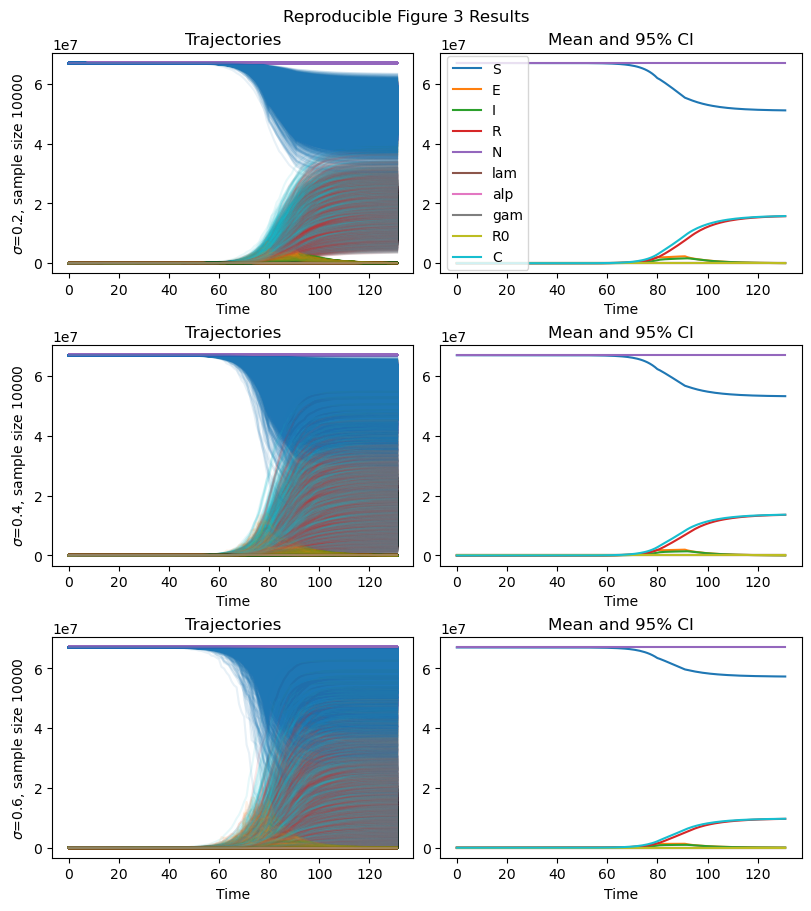

In [13]:
fig_compare_kwargs_fig_3 = deepcopy(fig_compare_kwargs)
fig_compare_kwargs_fig_3['figsize'] = (fig_compare_kwargs['figsize'][0], 3.0 * len(ssr_metadata_fig_3.keys()))
fig, axs = plt.subplots(len(ssr_metadata_fig_3.keys()), 2, **fig_compare_kwargs_fig_3)

for i, sig in tqdm(enumerate(ssr_results_fig_3.keys()), total=len(ssr_results_fig_3.keys()), leave=False):

       res = ssr_results_fig_3[sig]

       ssr_results_fig_3_sz = max(res.keys())

       r: sde.SDEResultSample = res[ssr_results_fig_3_sz]
       r.plot(fig_axs=(fig, [axs[i][0]] * len(Faranda2020.variable_names)), plot_all_kwargs=dict(alpha=0.1))

       r.plot_ci(confidence, fig_axs=(fig, [axs[i][1]] * len(Faranda2020.variable_names)), 
                 plot_all_kwargs=dict(alpha=0.25))
       r.plot_mean(fig_axs=(fig, [axs[i][1]] * len(Faranda2020.variable_names)), 
                   plot_kwargs={n: dict(label=n) for n in Faranda2020.variable_names})

       axs[i][0].set_title('Trajectories')
       axs[i][1].set_title(f'Mean and {int(confidence * 100)}% CI')
       axs[i][0].set_ylabel(f'$\\sigma$={sig}, sample size {ssr_results_fig_3_sz}')
fig.suptitle(f'Reproducible Figure 3 Results')
_ = axs[0][1].legend(loc='center left')

Show reproducible results for Figure 4.

  0%|          | 0/3 [00:00<?, ?it/s]

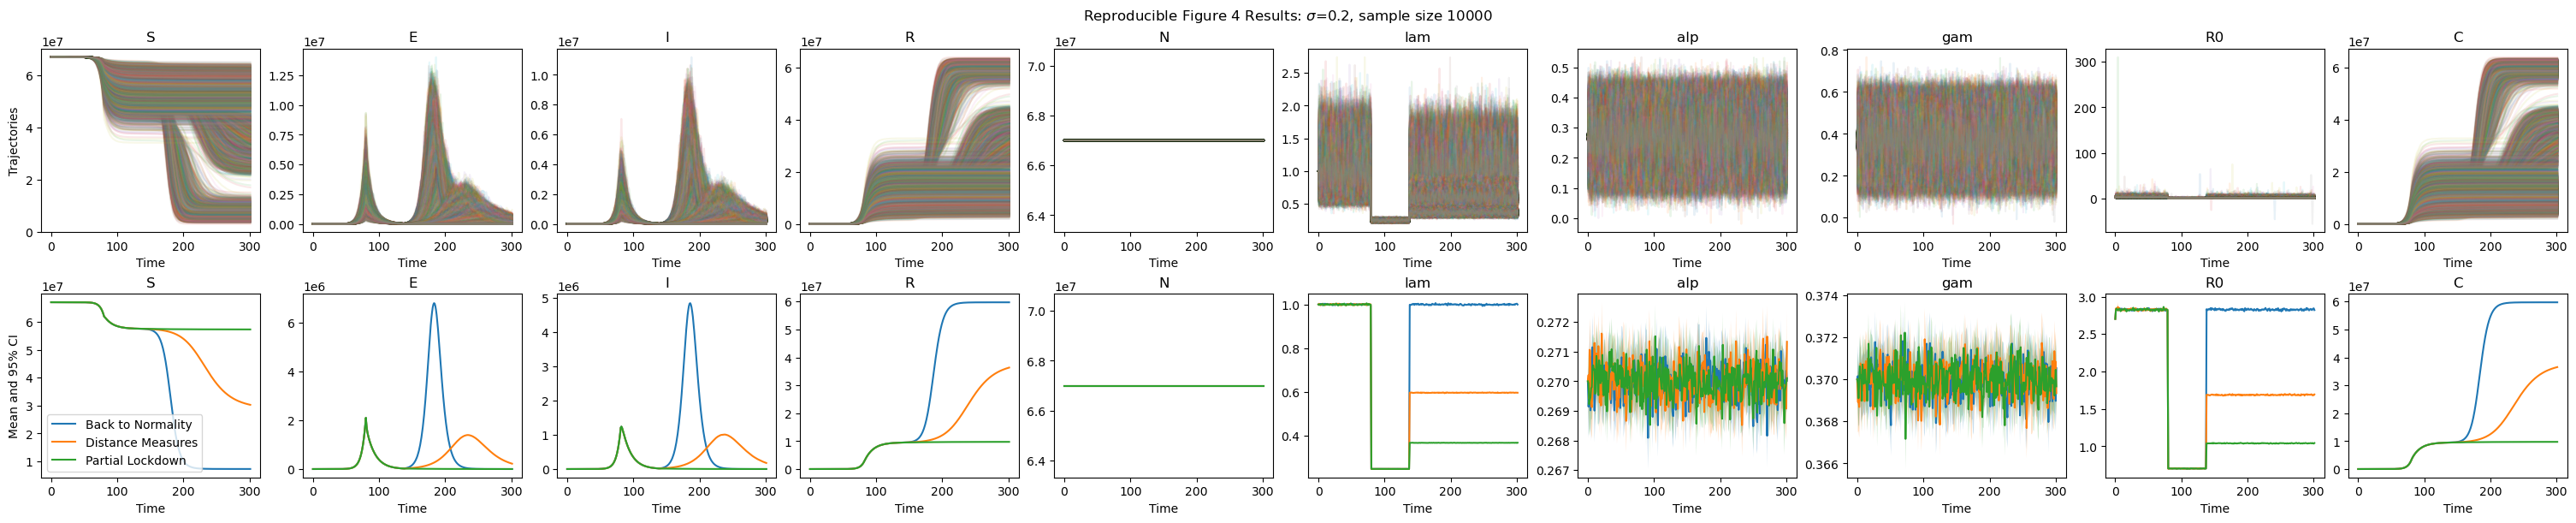

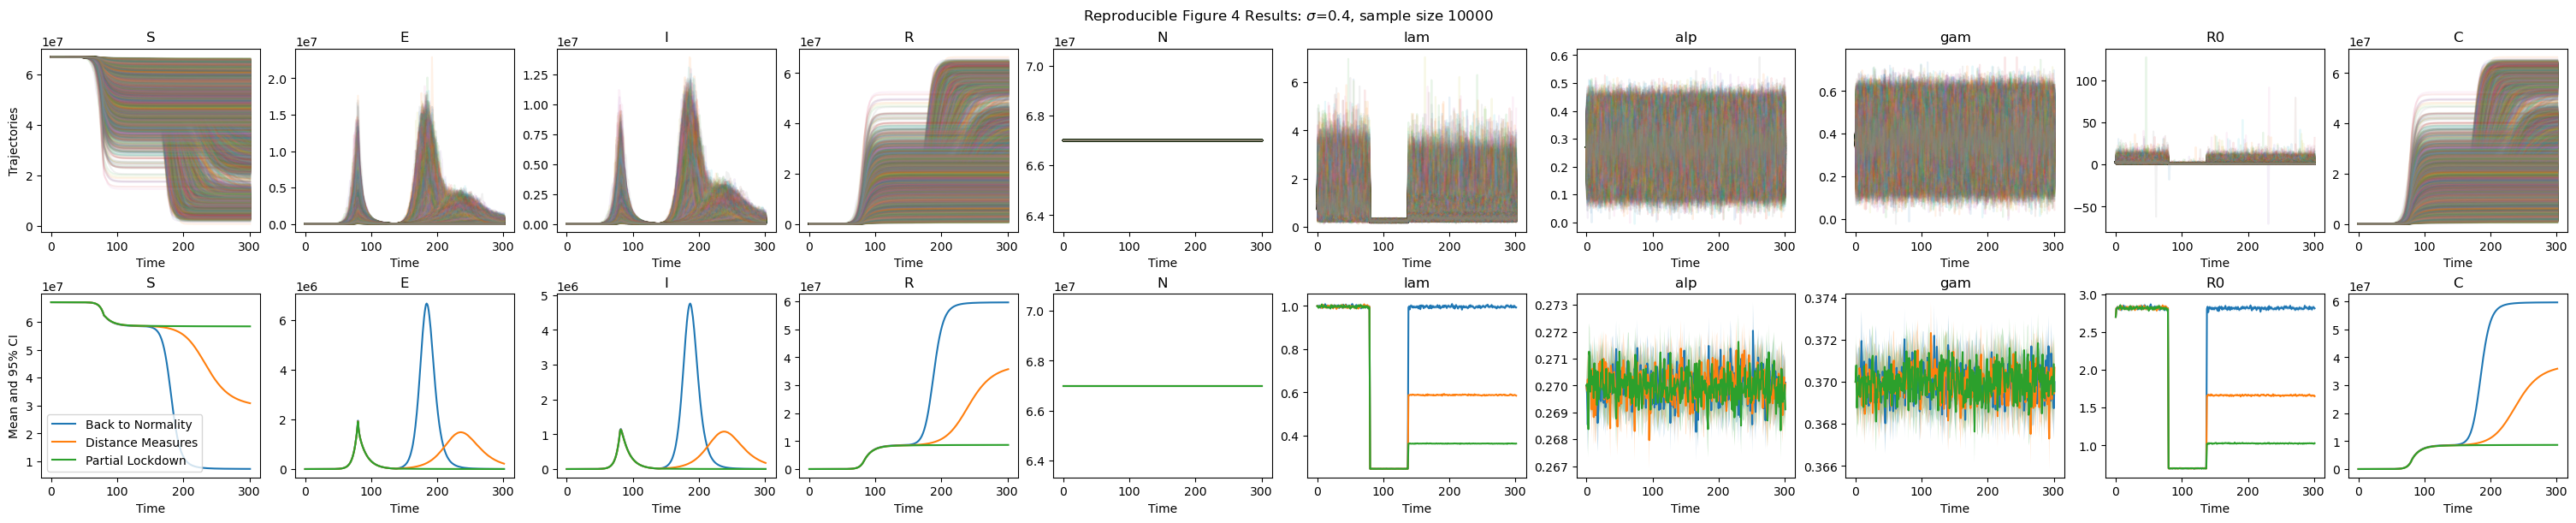

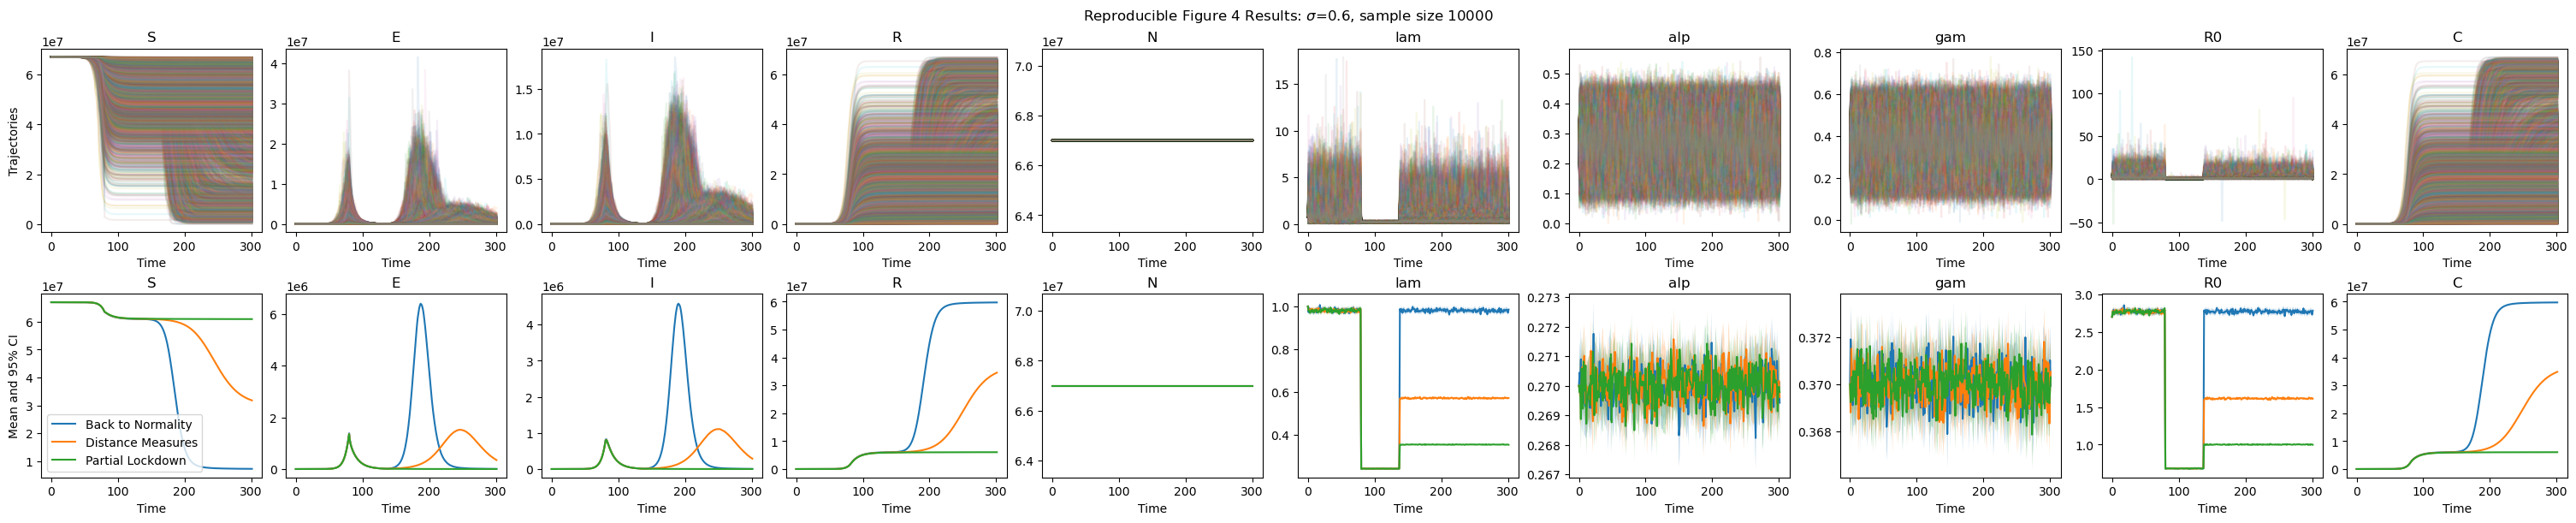

In [14]:
fig_compare_kwargs_fig_4 = deepcopy(fig_compare_kwargs)
fig_compare_kwargs_fig_4['figsize'] = (3.0 * len(Faranda2020.variable_names), 3.0 * 2)

for sig, ssr_results_fig_4_sig in tqdm(ssr_results_fig_4.items(), leave=False):

       fig, axs = plt.subplots(2, len(Faranda2020.variable_names), **fig_compare_kwargs_fig_4)

       for i, ival in enumerate(ssr_results_fig_4_sig.keys()):

              res = ssr_results_fig_4_sig[ival]

              ssr_results_fig_4_sz = max(res.keys())

              r: sde.SDEResultSample = res[ssr_results_fig_4_sz]
              r.plot(fig_axs=(fig, axs[0]), plot_all_kwargs=dict(alpha=0.1))

              r.plot_ci(confidence, fig_axs=(fig, axs[1]), 
                        plot_all_kwargs=dict(alpha=0.25))
              r.plot_mean(fig_axs=(fig, axs[1]), 
                          plot_kwargs={n: dict(label=labels_fig_4[i]) for n in Faranda2020.variable_names})

       fig.suptitle(f'Reproducible Figure 4 Results: $\\sigma$={sig}, sample size {ssr_results_fig_4_sz}')
       axs[0][0].set_ylabel('Trajectories')
       axs[1][0].set_ylabel(f'Mean and {int(confidence * 100)}% CI')
       _ = axs[1][0].legend(loc='lower left')